In [1]:
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
import numpy as np
import matplotlib.pyplot as plt
import uuid
import os
import json

In [6]:
def get_peak_count(canvas: DensityCanvas):
    npeaks = 0
    for i in range(1, canvas._npoints_x-1):
        for j in range(1, canvas._npoints_y-1):
            if (
                canvas._density[i,j] > canvas._density[i-1,j] and
                canvas._density[i,j] > canvas._density[i+1,j] and
                canvas._density[i,j] > canvas._density[i,j+1] and
                canvas._density[i,j] > canvas._density[i,j-1] and
                canvas._density[i,j] > canvas._density[i+1,j+1] and
                canvas._density[i,j] > canvas._density[i+1,j-1] and
                canvas._density[i,j] > canvas._density[i-1,j+1] and
                canvas._density[i,j] > canvas._density[i-1,j-1]
            ):
                npeaks += 1
    return npeaks

In [19]:
def benchmark(canvas: DensityCanvas, gaussian_params, lattice_params, pubo_params, repetitions=100, dynamics=False, seed=None):

    n_centers = gaussian_params["n_centers"]
    min_distance = gaussian_params["min_distance"]
    padding = gaussian_params["padding"]
    amplitude = gaussian_params["amplitude"]
    variance = gaussian_params["variance"]
    try:
        num_x = lattice_params["num_x"]
        num_y = lattice_params["num_y"]
    except KeyError:
        pass
    spacing = lattice_params["spacing"]

    global_identifier = str(uuid.uuid4())
    os.makedirs("topology_benchmark_data/" + global_identifier)
    local_ids = []

    np.random.seed(seed)
    for _ in range(repetitions):

        local_identifier = str(uuid.uuid4())
        local_ids.append(local_identifier)
        path = "topology_benchmark_data/" + global_identifier + "/" + local_identifier
        os.makedirs(path)
    
        # randomize gaussians
        canvas.set_randomized_gaussian_density(
            n_centers=n_centers,
            amplitude=amplitude,
            variance=variance,
            minimal_distance=min_distance,
            padding=padding,
        )
        
        fig, _ = canvas.plotting_objects(draw_centers=True)
        fig.savefig(path+"/gaussians.png", bbox_inches='tight')
        plt.close(fig)

        # create lattice
        if lattice_params["type"] == "square":
            canvas.set_rectangular_lattice(
                num_x=num_x,
                num_y=num_y,
                spacing=spacing
            )
        elif lattice_params["type"] == "poisson":
            canvas.set_poisson_disk_lattice(
                spacing=spacing
            )
        
        fig, _ = canvas.plotting_objects(draw_centers=True, draw_lattice=True)
        fig.savefig(path+"/initial_lattice.png", bbox_inches='tight')
        plt.close(fig)
        
        canvas.calculate_pubo_coefficients(
            p=pubo_params["p"],
            params=pubo_params["estimated_params"]
        )

        # lattice dynamics
        if dynamics:
            canvas.lattice_dynamics(spacing=lattice_params["spacing"])
            fig, _ = canvas.plotting_objects(draw_centers=True, draw_lattice=True)
            fig.savefig(path+"/dynamics_lattice.png", bbox_inches='tight')
            plt.close(fig)

        # reduce lattice
        canvas.force_lattice_size(lattice_params["n_points"])
        fig, _ = canvas.plotting_objects(draw_centers=True, draw_lattice=True)
        fig.savefig(path+"/final_lattice.png", bbox_inches='tight')
        plt.close(fig)

        # calculate energy levels
        N = len(canvas._lattice._coords)
        levels = {}
        for b in range(2**N):
            bitstring = format(b, '0'+str(N)+'b') # transform number into bitstring
            levels[bitstring] = canvas.calculate_bitstring_cost_from_coefficients(bitstring)
        levels = dict(sorted(levels.items(), key=lambda item: item[1]))

        # save data
        data = {}
        data["global_identifier"] = global_identifier
        data["local_identifier"] = local_identifier
        data["gaussian_params"] = gaussian_params
        data["lattice_params"] = lattice_params
        data["pubo_params"] = pubo_params
        data["energy_levels"] = levels
        data["n_peaks"] = get_peak_count(canvas)
        data["n_points"] = N

        with open(path + "/data.json", "w") as data_out:
            json.dump(data, data_out, indent=4)

    
    with open("topology_benchmark_data/"+global_identifier+"/identifiers.txt", "w") as id_out:
        for id in local_ids:
            id_out.write(f"{id}\n")

In [20]:
# define a canvas
origin = (-40, -40)
length = 80
npoints = 160
canvas = DensityCanvas(
    origin=origin,
    length_x=length,
    length_y=length,
    npoints_x=npoints,
    npoints_y=npoints,
)
# this is an empty canvas of length 40x40 with 80 points in each direction
# (so a resolution of 2 points per unit length)

In [21]:
gaussian_params = {
    "n_centers": 5, #number of Gaussians
    "min_distance": 10, #minimal distance between gaussians
    "padding": 20, #minimal distance of Gaussian centers from border
    "amplitude": 20, #amplitude of the Gaussians
    "variance": 50, #variance of the Gaussians
}

lattice_params = {
    "type": "square",
    "num_x": 6,
    "num_y": 6,
    "spacing": 8,
    "n_points": 14
}

pubo_params = {
    "p": 2,
    "estimated_params": [20, 50]
}

benchmark(canvas, gaussian_params, lattice_params, pubo_params, repetitions=3, seed=42)

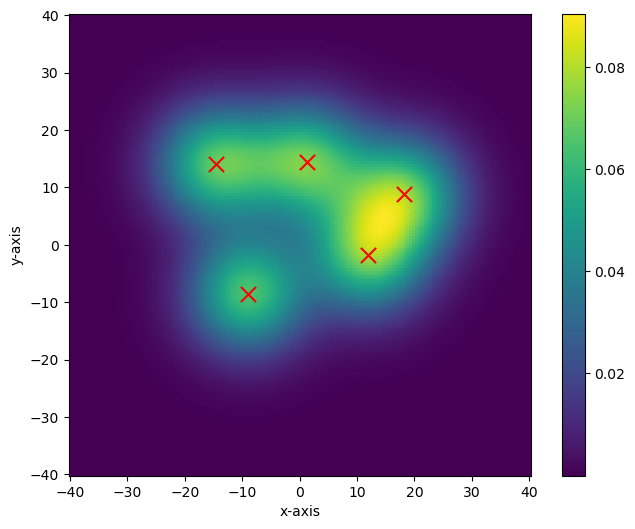

In [63]:
# extract random centers with a minimal distance
# and a padding from border
seed = 123486
n_centers = 5 #number of Gaussians
min_dist = 10 #minimal distance between gaussians
padding = 20 #minimal distance of Gaussian centers from border
amplitude = 20 #amplitude of the Gaussians
variance = 50 #variance of the Gaussians

canvas.set_randomized_gaussian_density(
    n_centers = n_centers,
    amplitude = amplitude,
    variance = variance,
    minimal_distance = min_dist,
    padding = padding,
    seed = seed
)

# To see the result, call the draw method with draw_centers=True
canvas.draw(draw_centers=True, figsize=(8,6))

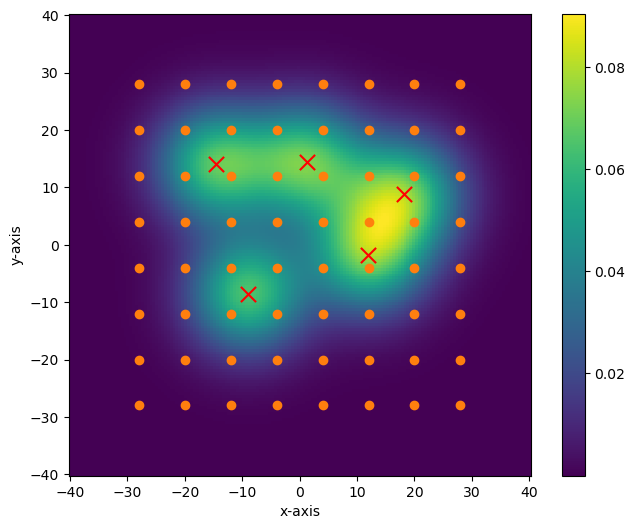

In [69]:
# Define a 8x8 rectangular lattice with spacing of 4
canvas.set_rectangular_lattice(num_x=8, num_y=8, spacing=8)
canvas.draw(draw_centers=True, draw_lattice=True, labels=False, figsize=(8,6))


# Define a Poisson disk lattice.
#canvas.set_poisson_disk_lattice(spacing=(2,10))
#canvas.draw(draw_centers=True, draw_lattice=True, labels=False, figsize=(8,6))


In [70]:
canvas.lattice_dynamics(spacing=5, save_history=True)

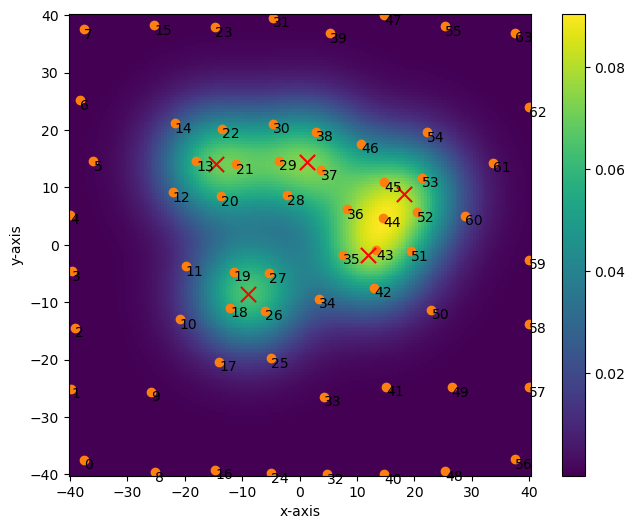

In [71]:
canvas.draw(draw_centers=True, draw_lattice=True, labels=True, figsize=(8,6))

In [72]:
estimated_variance = 30
estimated_amplitude = 10

canvas.calculate_pubo_coefficients(
    p = 2, #order of the PUBO, p=2 effectively creates a QUBO
    params = [estimated_amplitude, estimated_variance]
)

canvas.force_lattice_size(16)

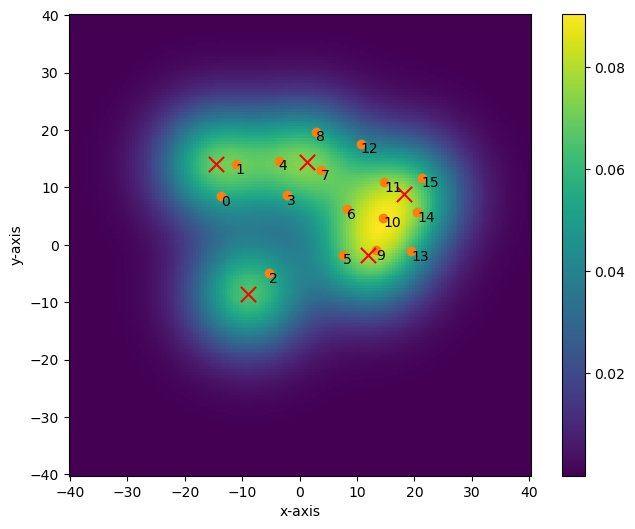

In [73]:
canvas.draw(draw_centers=True, draw_lattice=True, labels=True, figsize=(8,6))

In [74]:
canvas.lattice_dynamics(spacing=5, save_history=True)

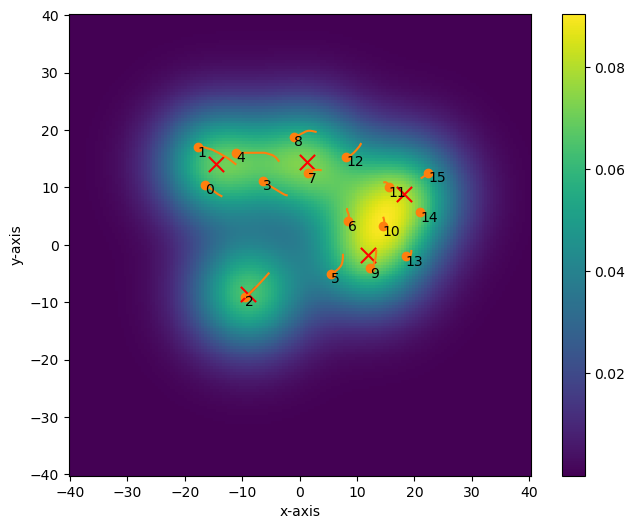

In [75]:
canvas.draw(draw_centers=True, draw_lattice=True, labels=True, lattice_history=True, figsize=(8,6))